In [1]:
import os
os.chdir("..")

In [2]:
from configs.parser import Parser

C = Parser("configs/default.yaml").C.data
C

dataset:
  mode: fine
  root: ./cityscapes
  target_type: semantic
loader:
  batch_size: 6
name: cityscapes

In [3]:
from datas import get_loader

train_loader = get_loader(C, "train", distributed=False)
valid_loader = get_loader(C, "val", distributed=False)

cityscapes {'root': './cityscapes', 'mode': 'fine', 'target_type': 'semantic'} train
cityscapes {'root': './cityscapes', 'mode': 'fine', 'target_type': 'semantic'} val


In [29]:
import matplotlib.pyplot as plt
from torchvision import transforms


to_pil = transforms.ToPILImage()


def plot(img, mask):
    img = to_pil(img).convert("RGB")
    mask = mask.numpy()[0]
    mask[mask == 255] = 0
    
    fig, ax  = plt.subplots(1, 2)
    ax[0].set_title("Image")
    ax[0].imshow(img)
    ax[1].set_title(f"Mask : {np.unique(mask)}")
    ax[1].imshow(mask)
    plt.show()

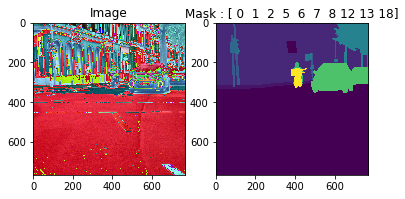

In [30]:
for img, mask in train_loader.dataset:
    plot(img, mask)
    break

In [ ]:
import torch
from model import deeplabv3, PointHead, PointRend
from torchvision.models.utils import load_state_dict_from_url

device = torch.device("cuda")
net = PointRend(
  deeplabv3(**C.net.deeplab),
  PointHead(**C.net.pointhead)
).to(device)
state_dict = load_state_dict_from_url('*.pth', progress=True)
net.load_state_dict(state_dict)
net.eval()
print("Done")

In [ ]:
for img, mask in train_loader.dataset:
  with torch.no_grad():
    res2, out = net(img)
    
  res2, out
  break


<Figure size 432x288 with 0 Axes>

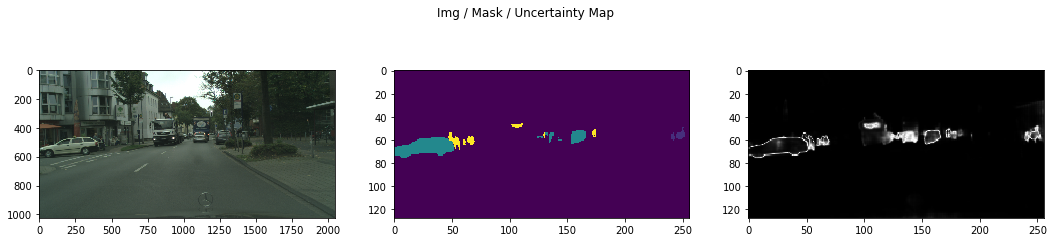

In [ ]:
import matplotlib.pyplot as plt


with torch.no_grad():
    plt.figure()
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle("Img / Mask / Uncertainty Map")
    # softmax for normalize
    pred = out.softmax(1).argmax(1).float()
    
    """
    In Paper,
    To measure prediction uncertainty
    we use the same strategy during training and inference:
    the difference between the most confident
    and second most confident class probabilities
    """
    v, i = out.softmax(1).sort(1, descending=True)
    # uncertainty = (v[:, -1, :, :] - v[:, -2, :, :]) <= 0.5
    uncertainty = - (v[:, 0, :, :] - v[:, 1, :, :])
    
    # ax[0].imshow(input_pil)
    ax[1].imshow(pred[0].numpy())
    ax[2].imshow(uncertainty[0].numpy(), cmap="gray")
    plt.show()